In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
setup_logging(epoch_key)

In [5]:
from dask.distributed import Client

# for virga
client = Client(n_workers=28, threads_per_worker=2, processes=True)

client

/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37811 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:37947 Dashboard: http://127.0.0.1:37811/status,Cluster Workers: 28 Cores: 56 Memory: 1.62 TB


In [6]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

19-May-21 21:22:14 Loading position info...
19-May-21 21:22:51 Loading multiunit...
19-May-21 21:23:18 Loading spikes...
19-May-21 21:24:49 Finding ripple times...


In [7]:
continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'knot_spacing': 8,
    'spike_model_penalty': 0.5,
}

In [ ]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING, PROCESSED_DATA_DIR

from sklearn.model_selection import KFold
import os

state_names = ['Continuous', 'Fragmented']
cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = SortedSpikesClassifier(**classifier_parameters)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        spikes=data["spikes"].iloc[train],
        track_graph=data["track_graph"],
        edge_order=WTRACK_EDGE_ORDER,
        edge_spacing=WTRACK_EDGE_SPACING,
    )
    classifier.save_model(
        os.path.join(PROCESSED_DATA_DIR,
            f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_"
            f"sortedspikes_increase_smoothing_fold{fold_ind}_model.pkl")
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["spikes"].iloc[test],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate results 
results = xr.concat(
    results, dim="time"
)

# save the results as .nc format. ncread matlab can read these
results.to_netcdf(
    os.path.join(PROCESSED_DATA_DIR,
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_sortedspikes_increase_smoothing_results.nc")
)
logging.info('Done...\n\n')

19-May-21 21:25:41 Fitting Fold #1...
19-May-21 21:25:42 Fitting initial conditions...
19-May-21 21:25:43 Fitting state transition...
19-May-21 21:25:43 Fitting place fields...
19-May-21 21:27:23 Predicting posterior...


In [ ]:
client.close()

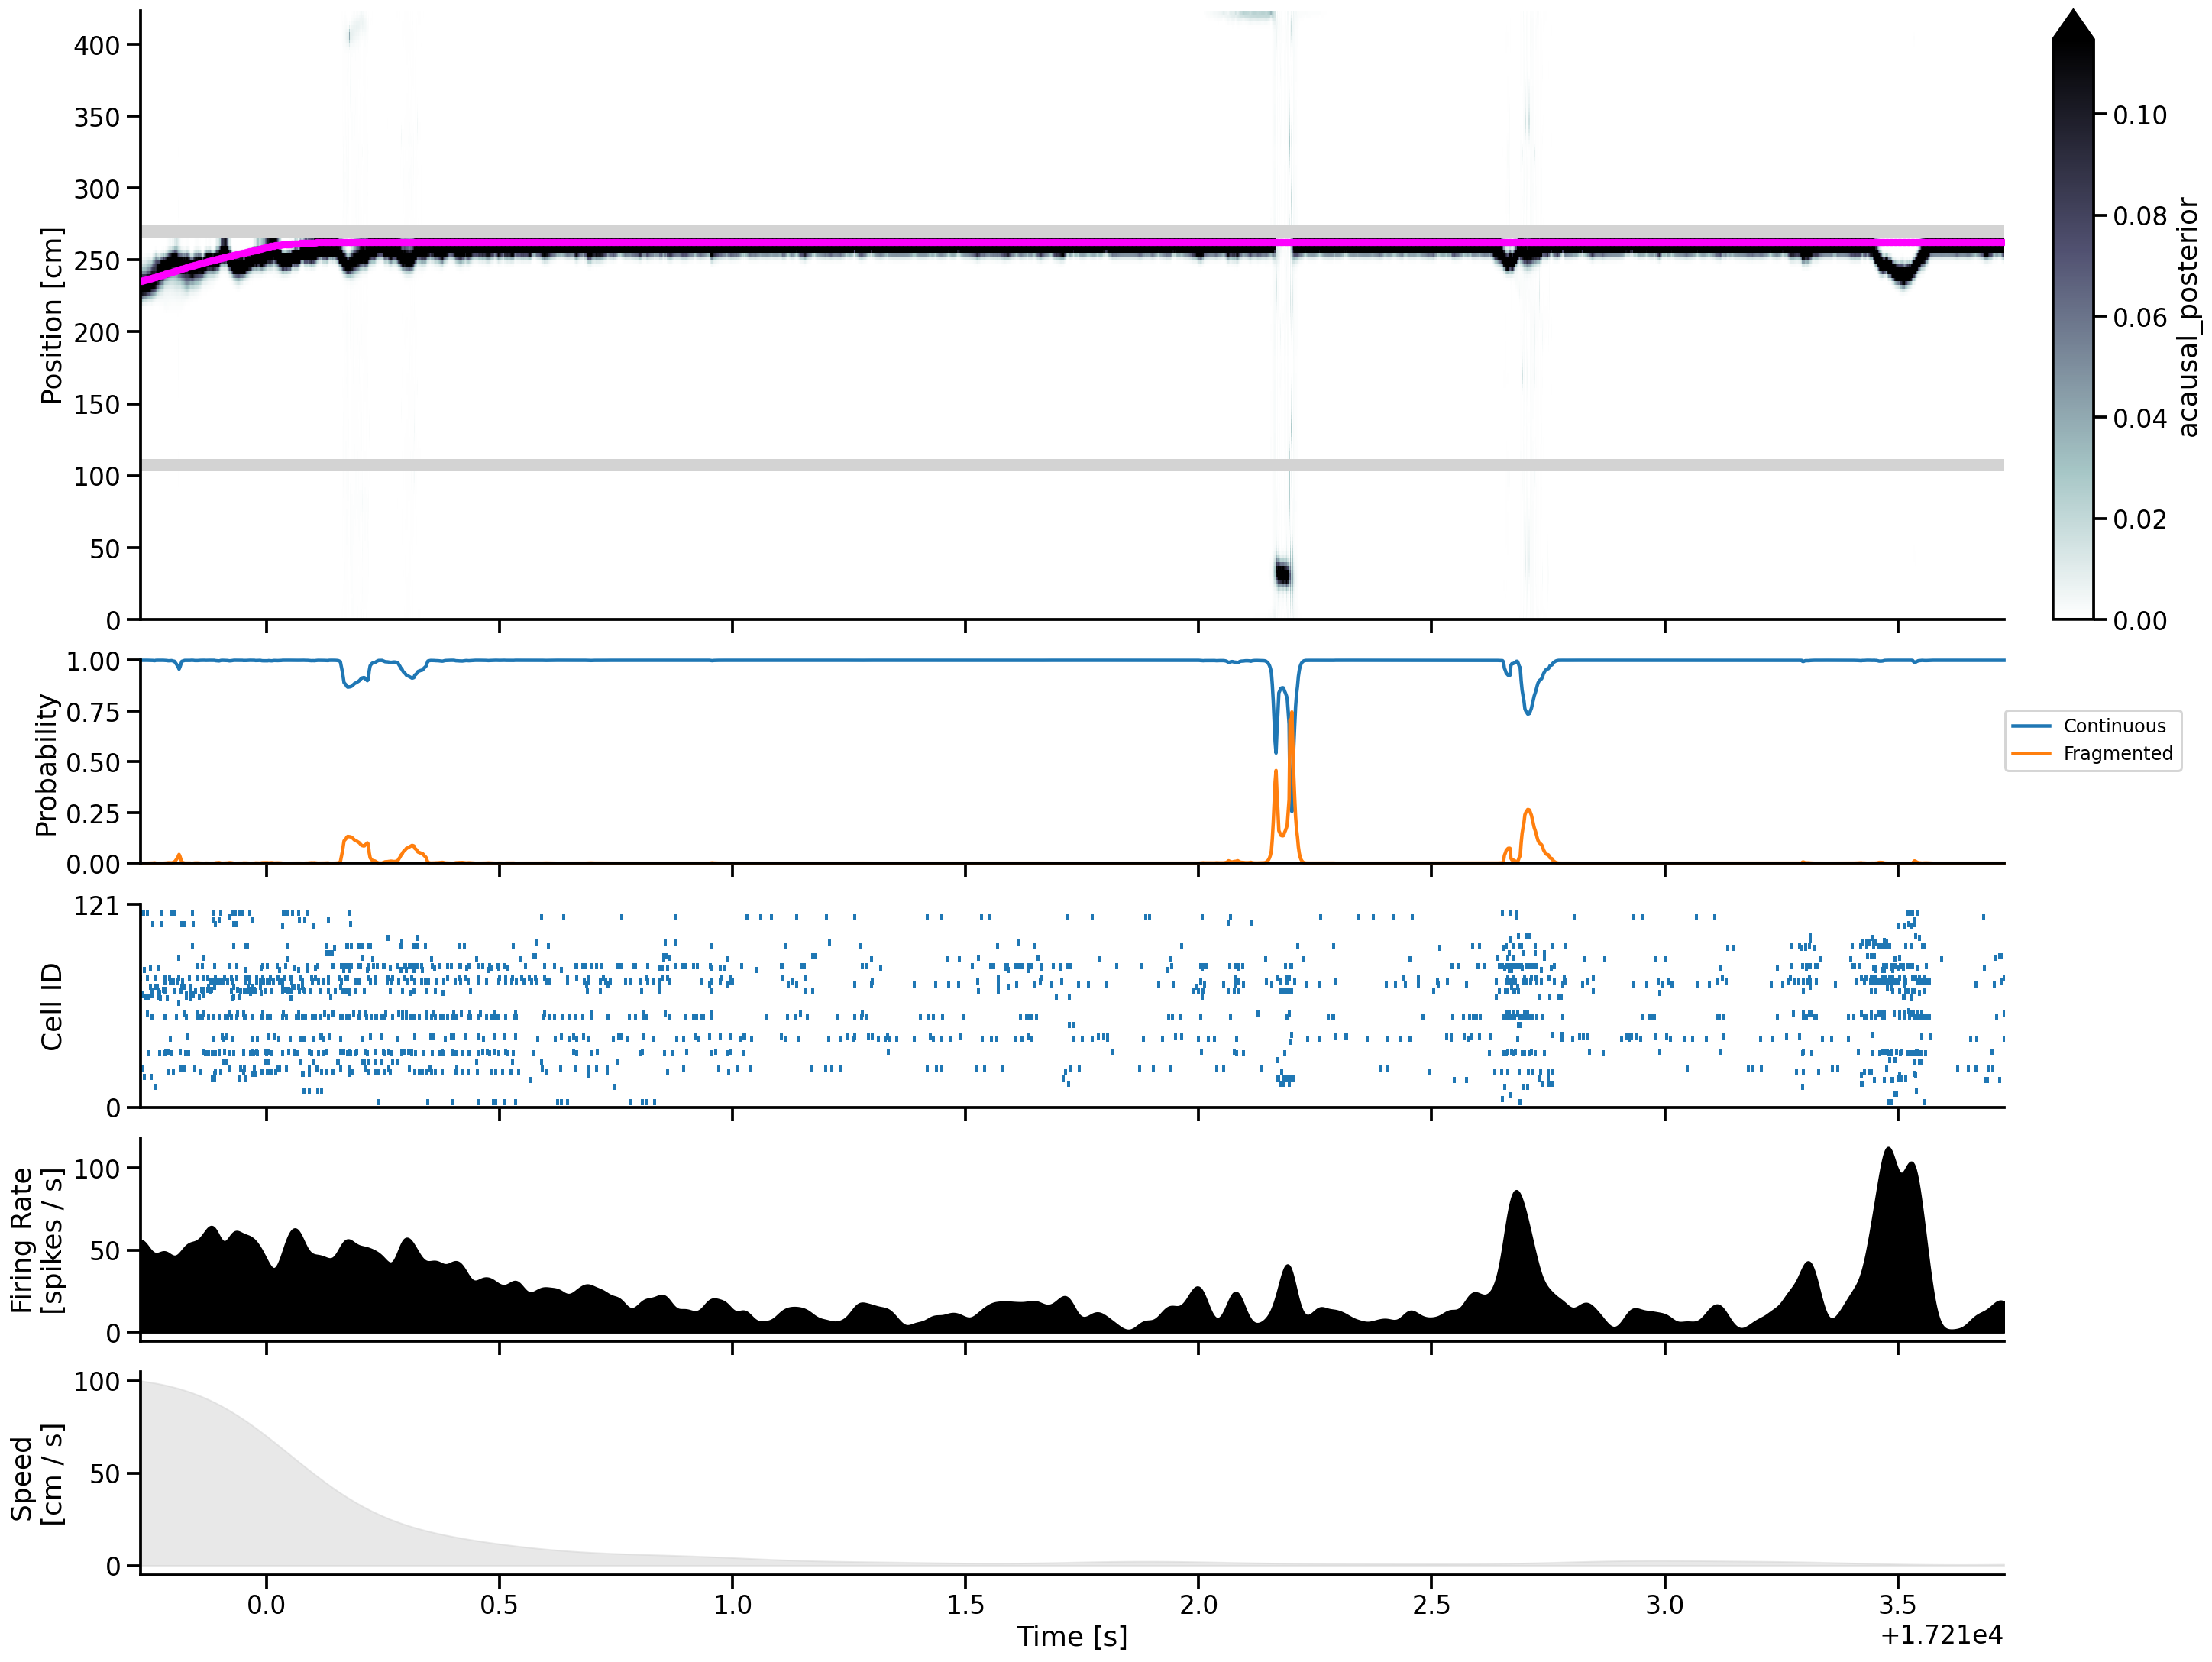

In [13]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(424_000, 426_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=True,
)

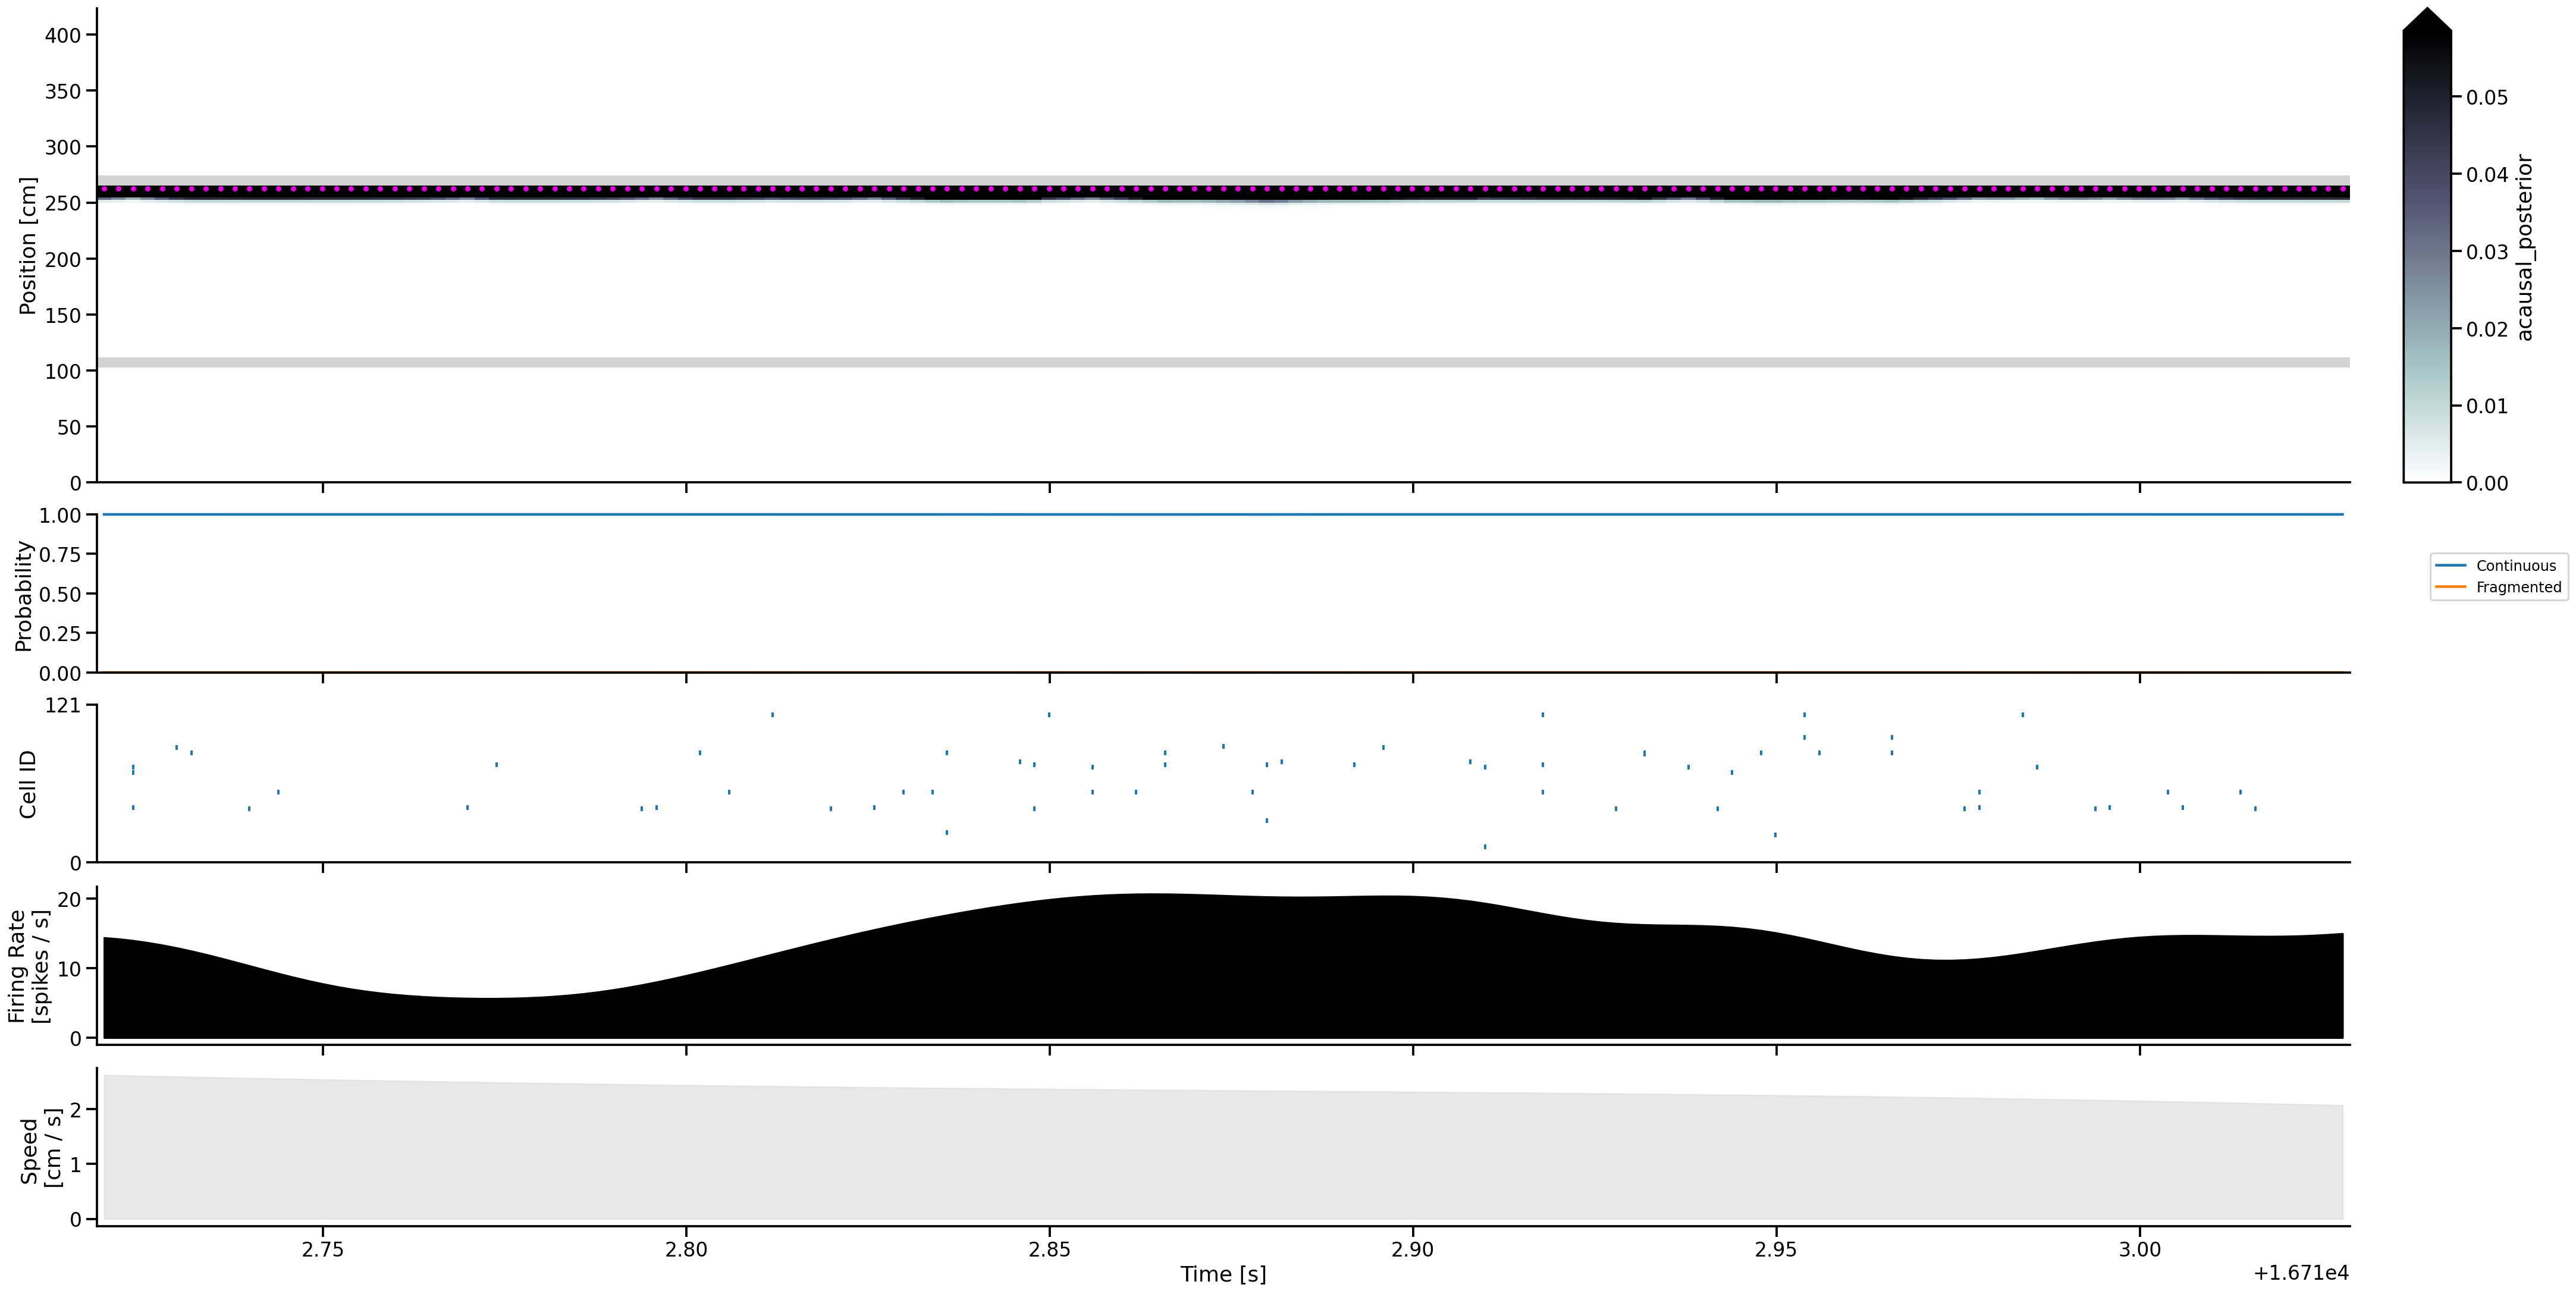

In [29]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(175_495, 175_650)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
    legend=True,
)

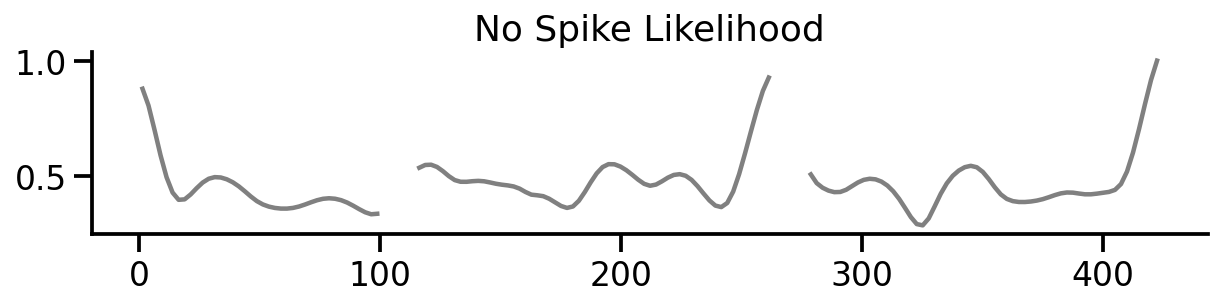

In [14]:
from replay_trajectory_classification.spiking_likelihood import estimate_spiking_likelihood
from replay_trajectory_classification.core import scaled_likelihood

n_neurons = data['spikes'].shape[1]
no_spike_likelihood = scaled_likelihood(estimate_spiking_likelihood(
    spikes=np.zeros((1, n_neurons)),
    conditional_intensity=np.asarray(classifier.place_fields_.sel(encoding_group=0)),
    is_track_interior=classifier.is_track_interior_), axis=-1).squeeze()

no_spike_likelihood[~classifier.is_track_interior_] = np.nan

plt.figure(figsize=(10, 5 / 3))
plt.plot(classifier.place_bin_centers_, no_spike_likelihood, color='grey')
plt.title('No Spike Likelihood')
sns.despine()

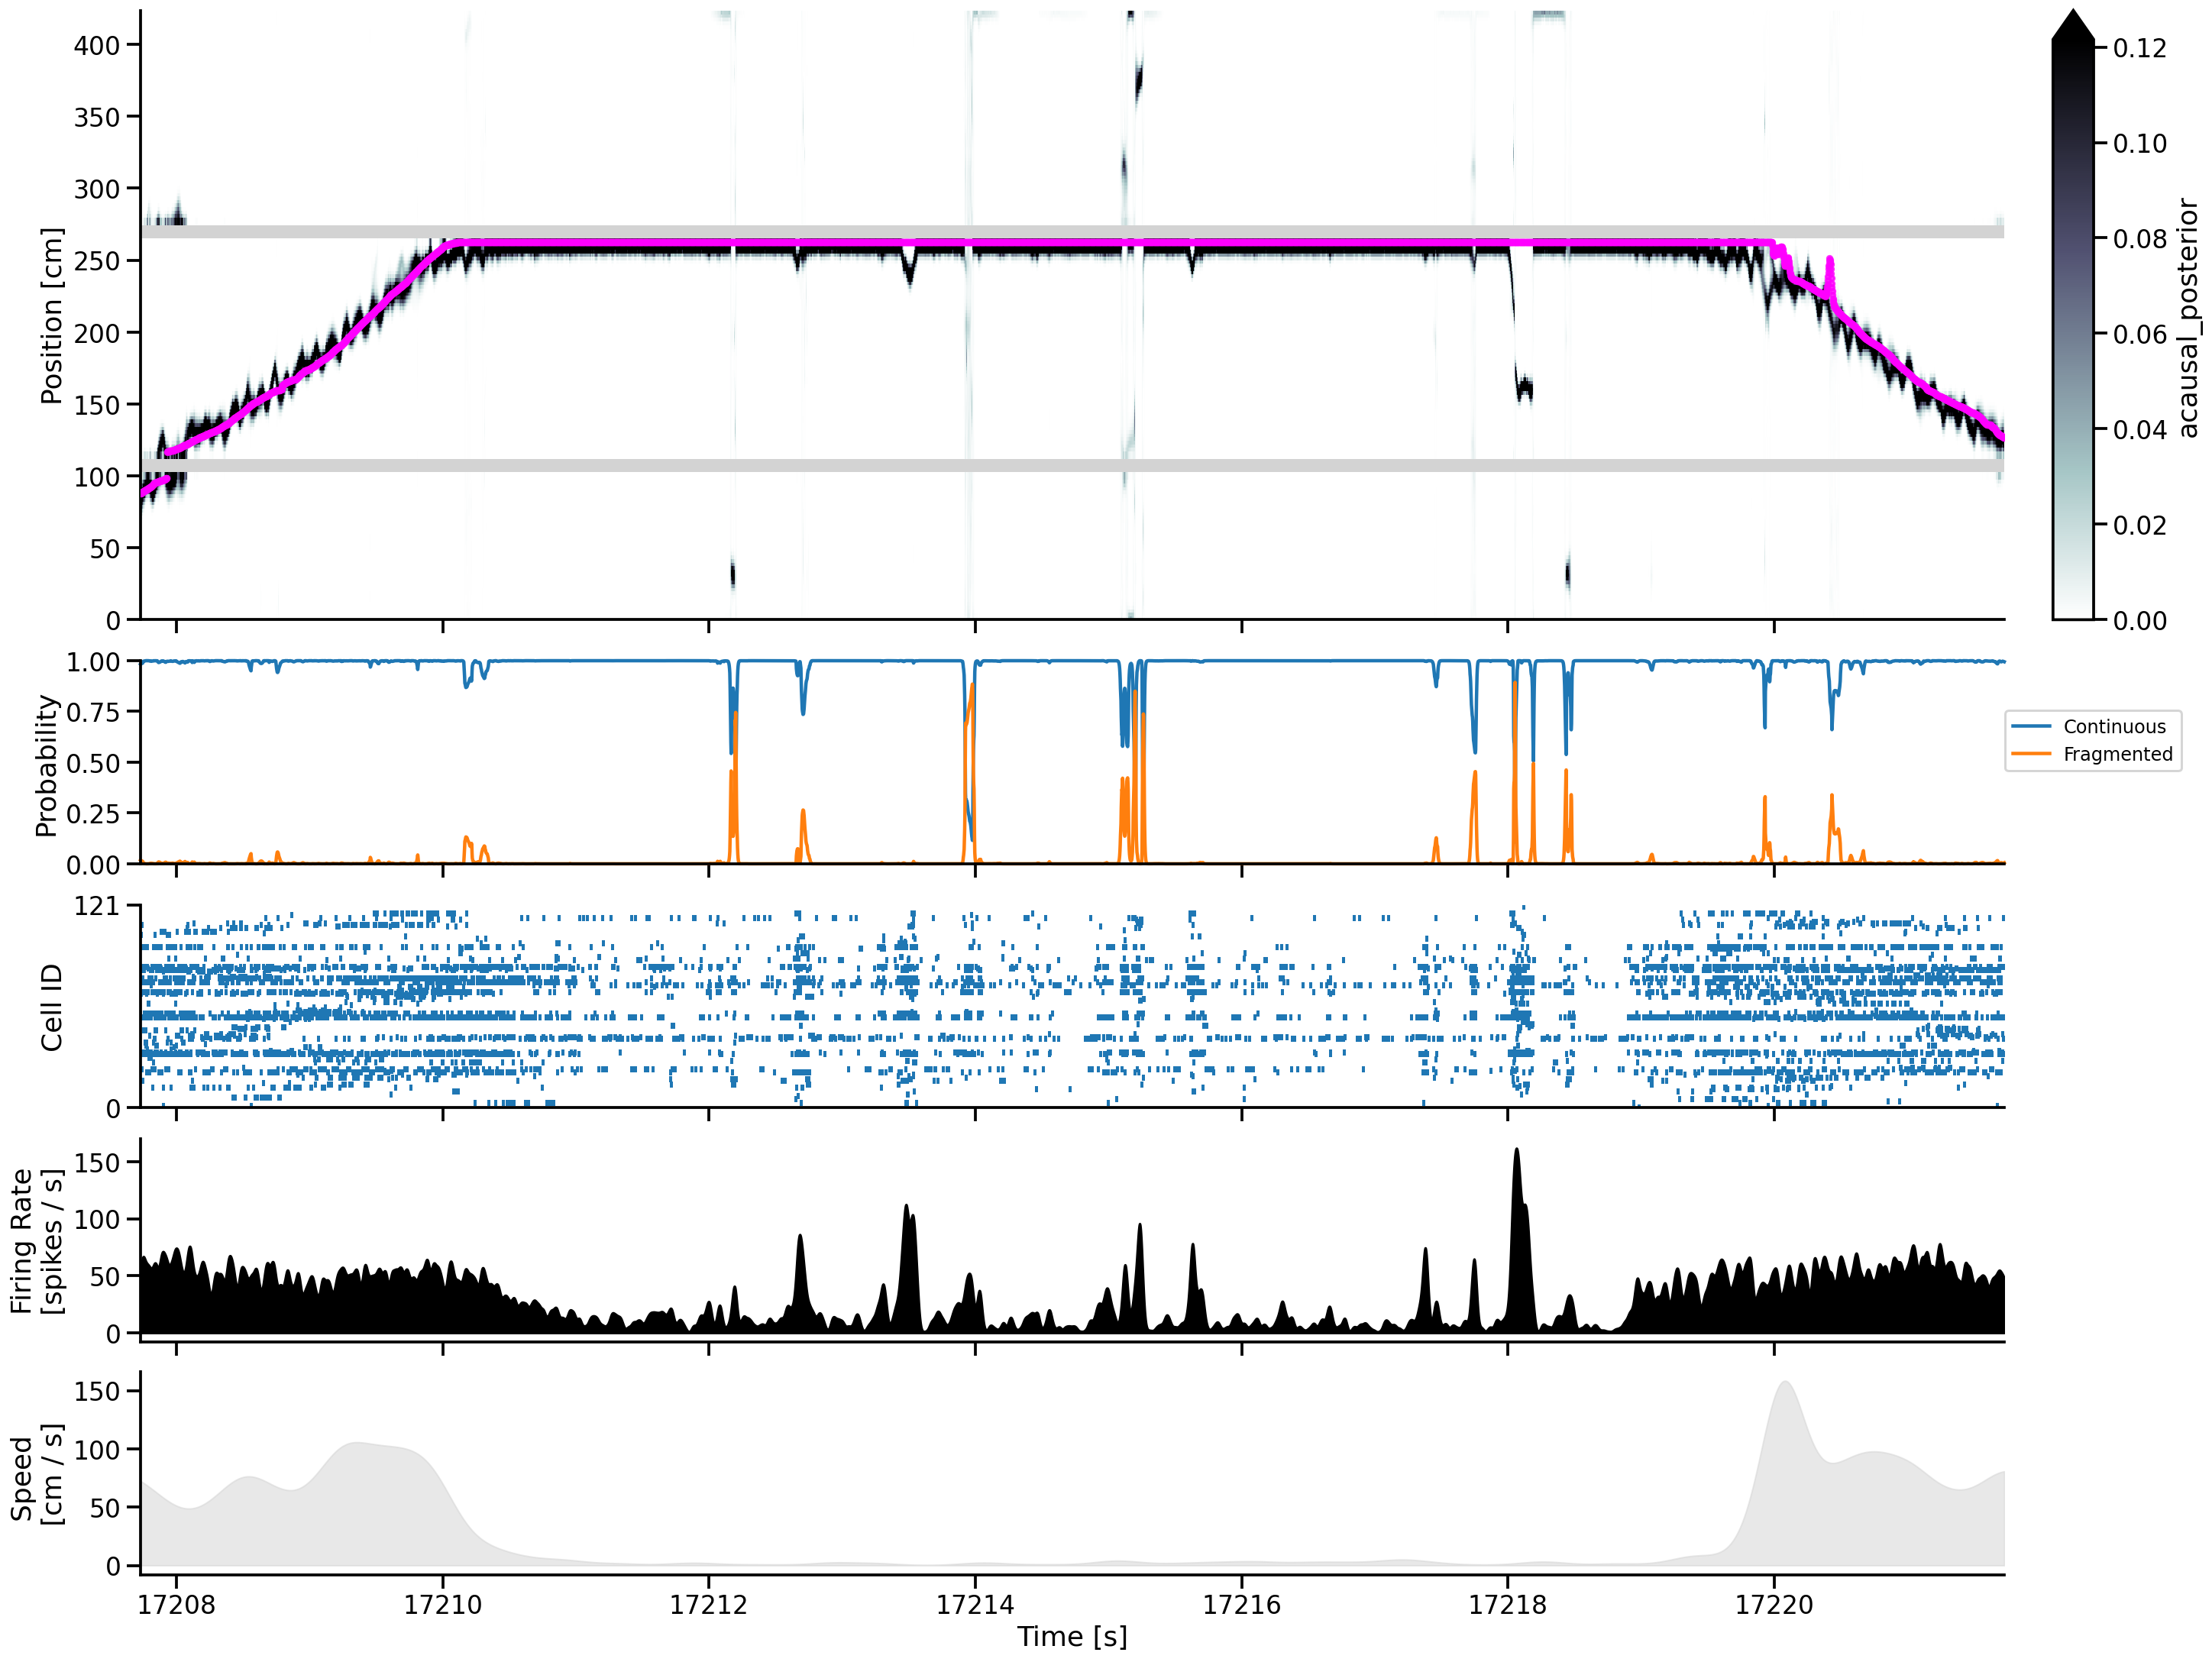

In [15]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(423_000, 430_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=True,
)

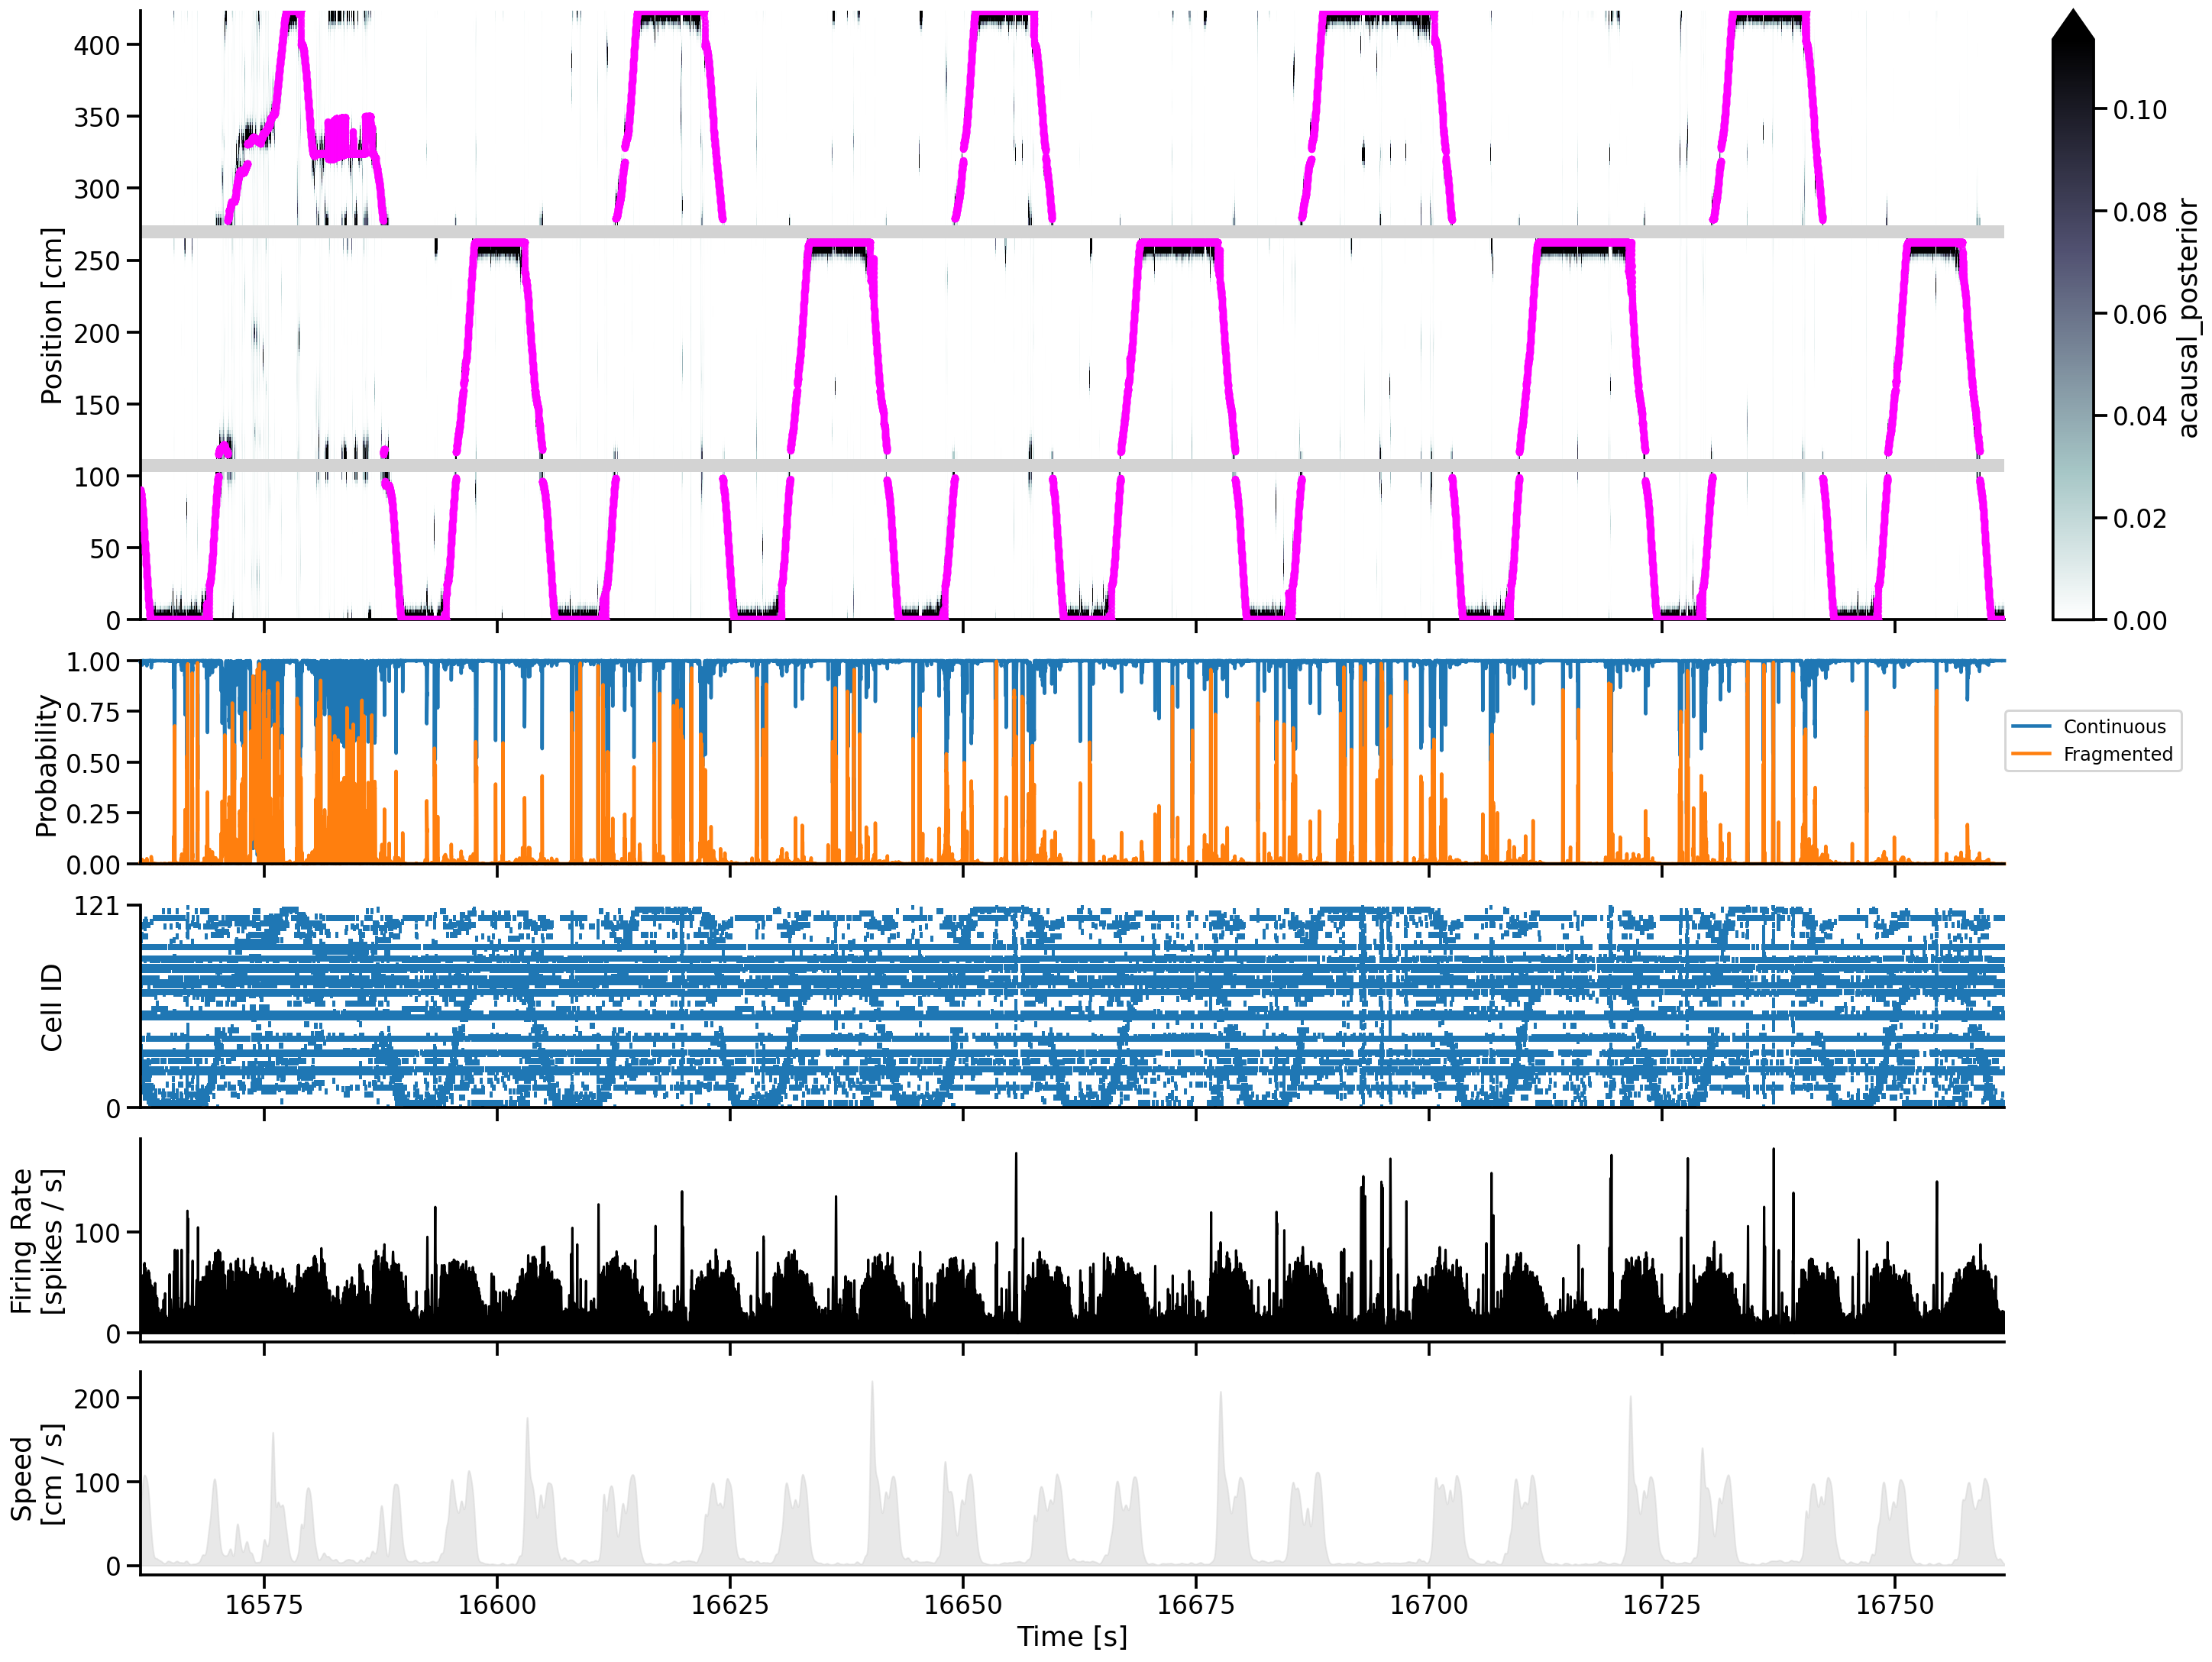

In [20]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(100_000, 200_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
    legend=True,
)

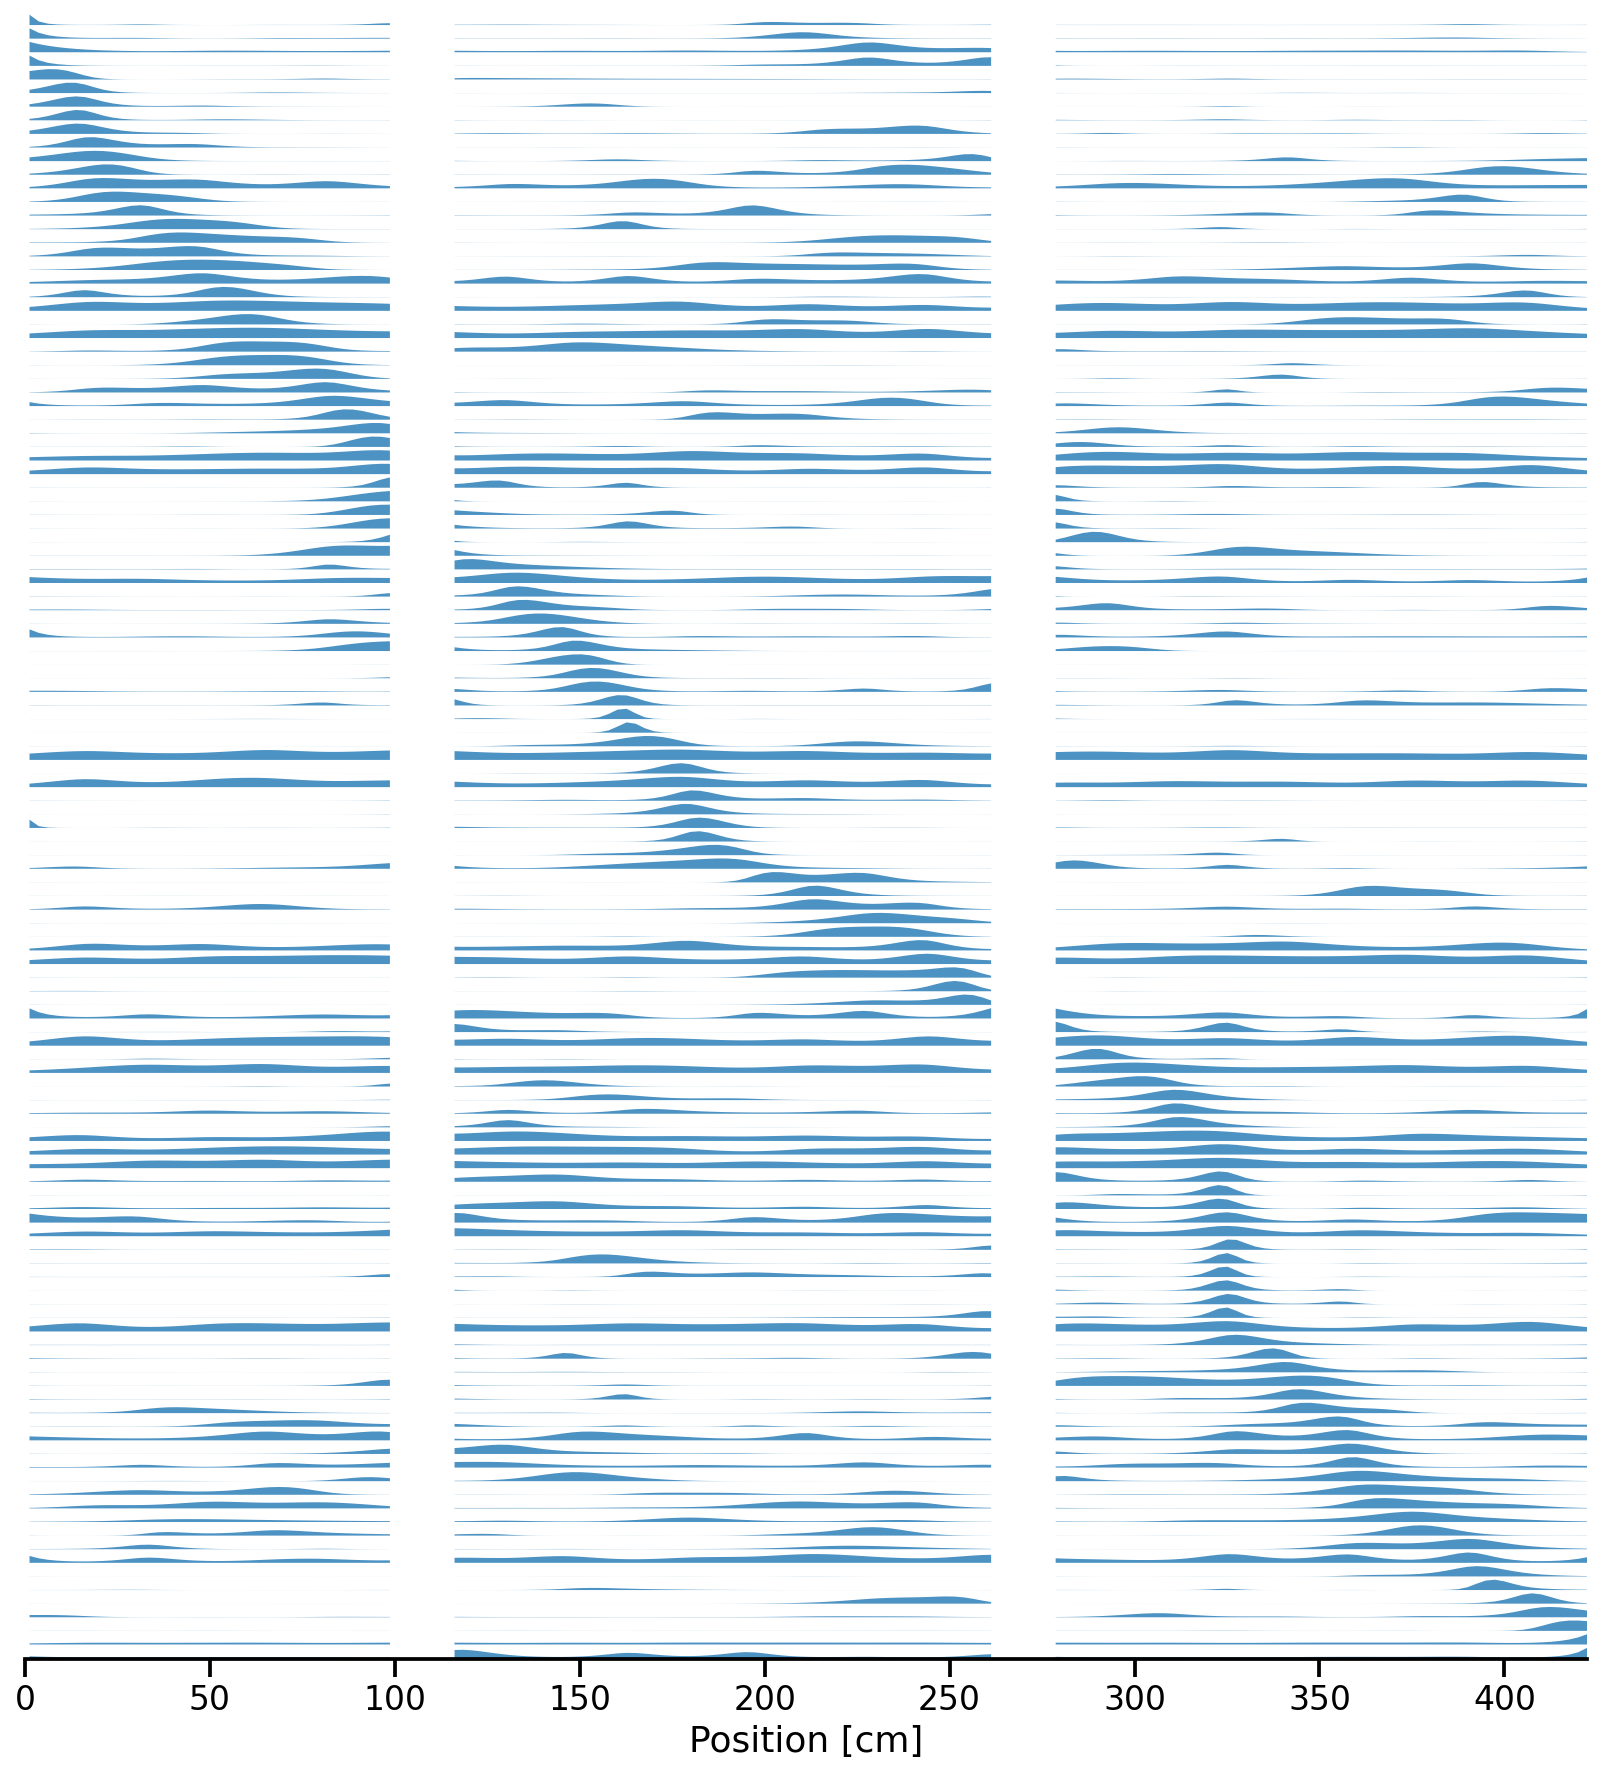

In [18]:
from src.visualization import plot_place_fields


plot_place_fields(classifier, sampling_frequency=500)

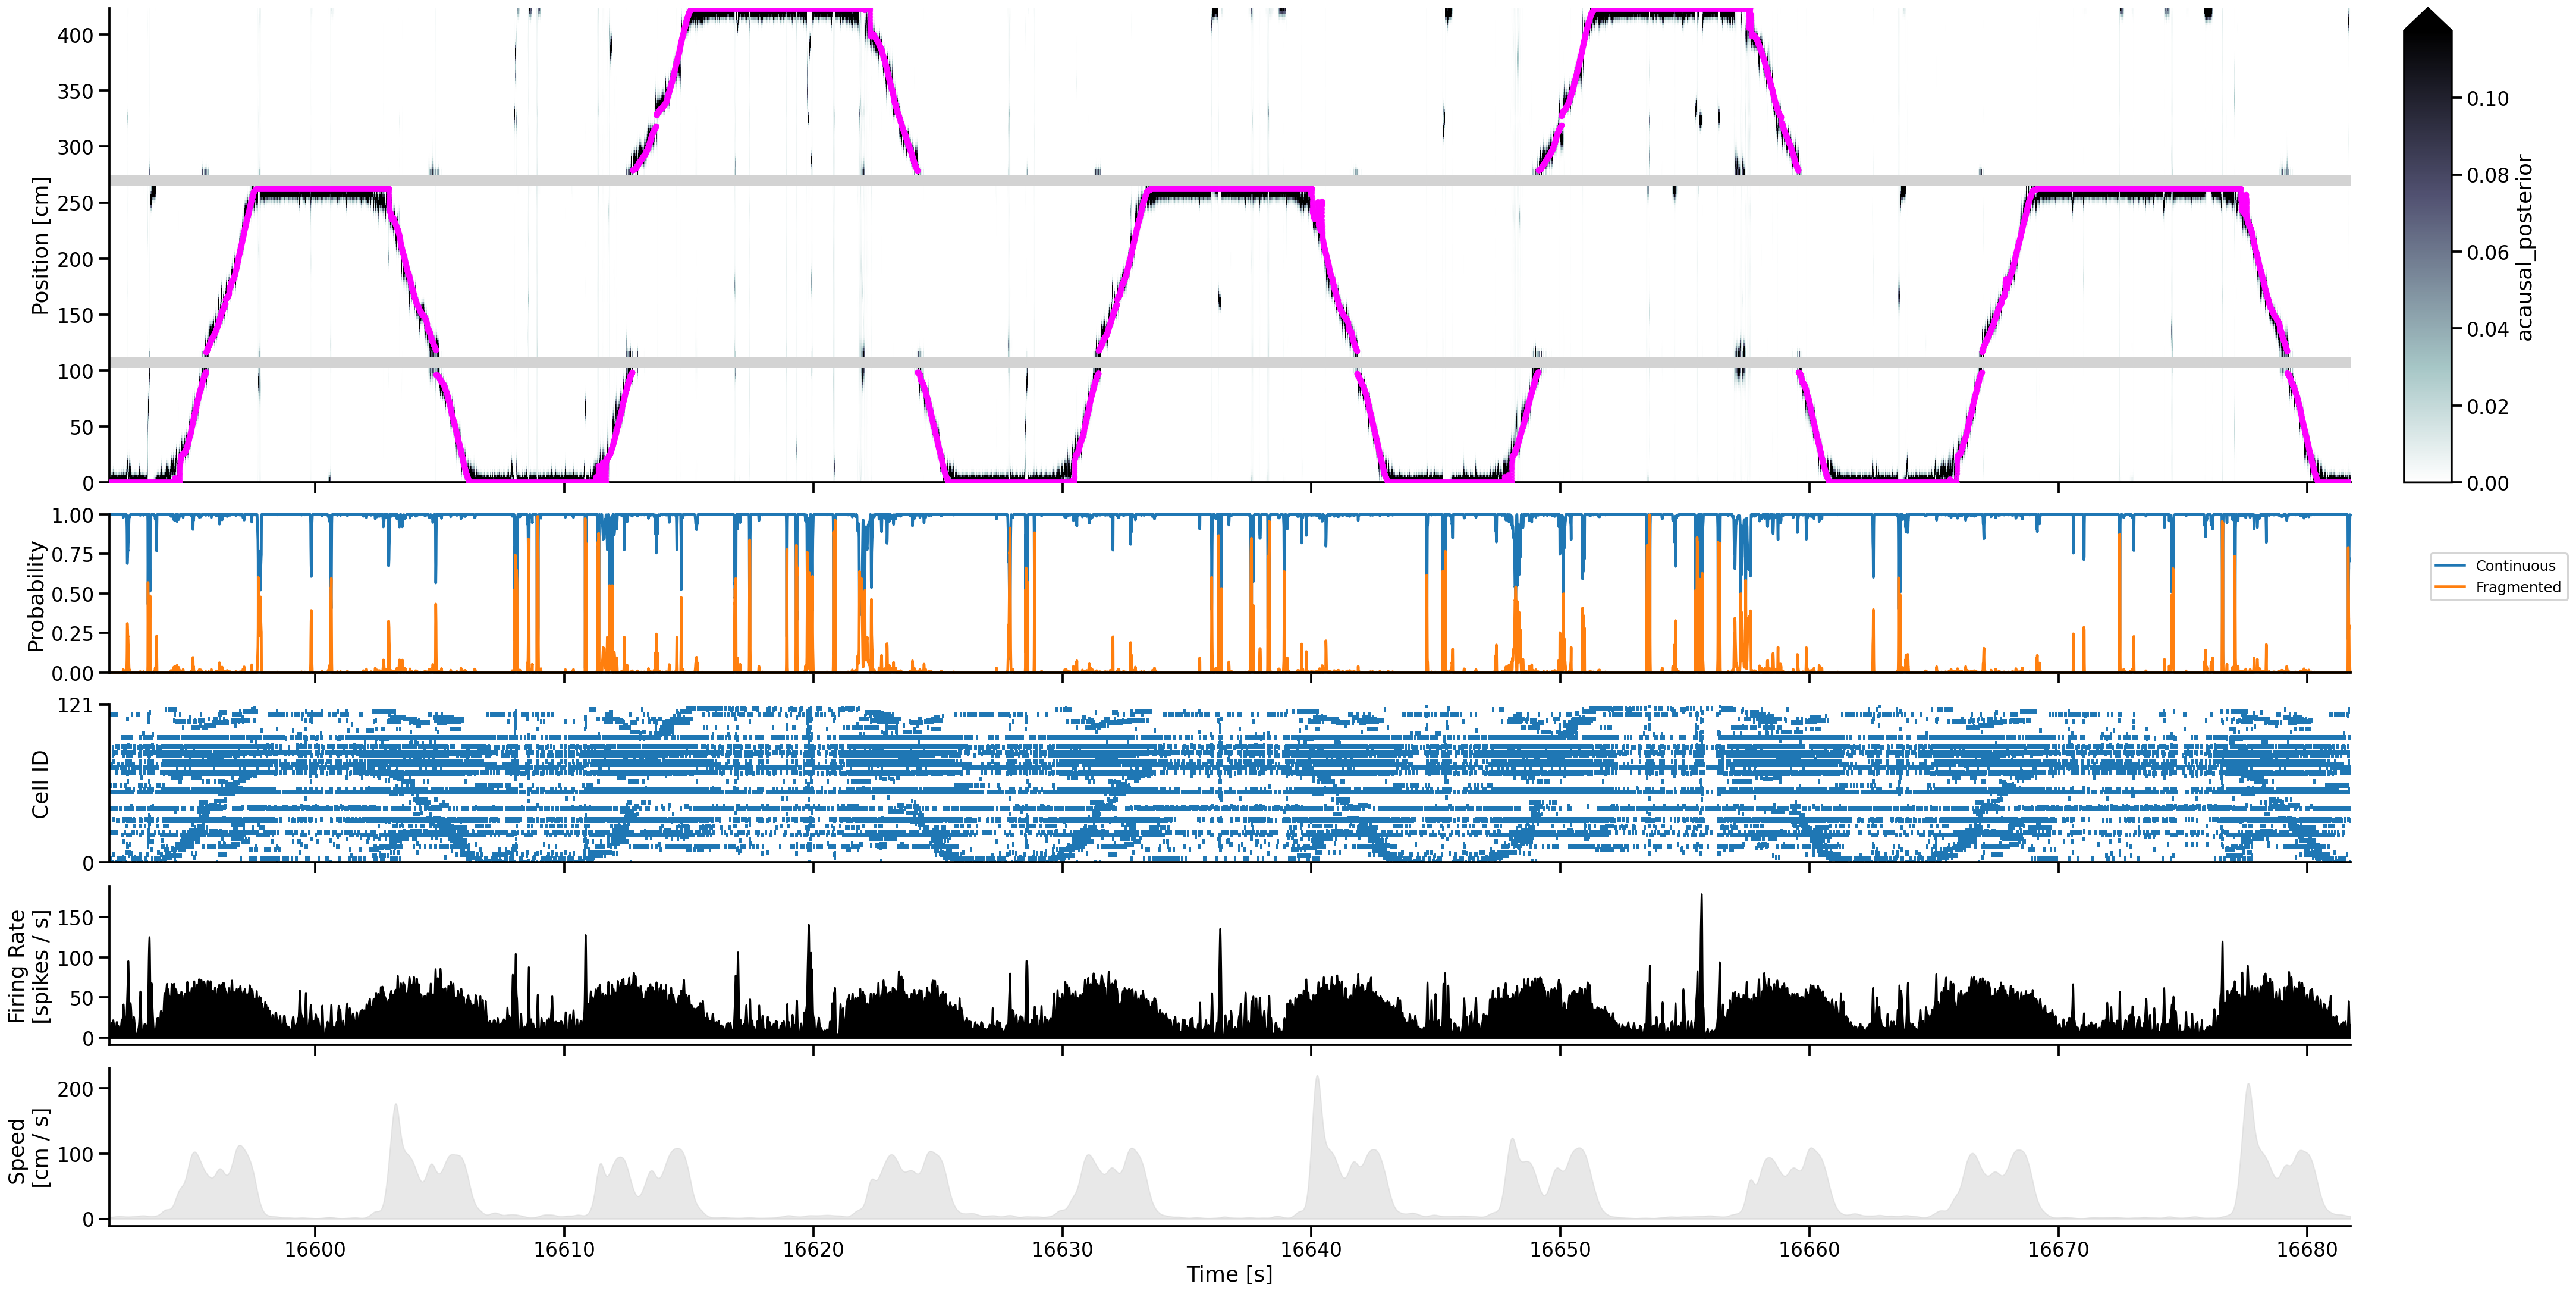

In [24]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(115_000, 160_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
    legend=True,
)

20-May-21 13:26:46 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
20-May-21 13:26:46 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3000x1500 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y animation_increase_smoothing.mp4


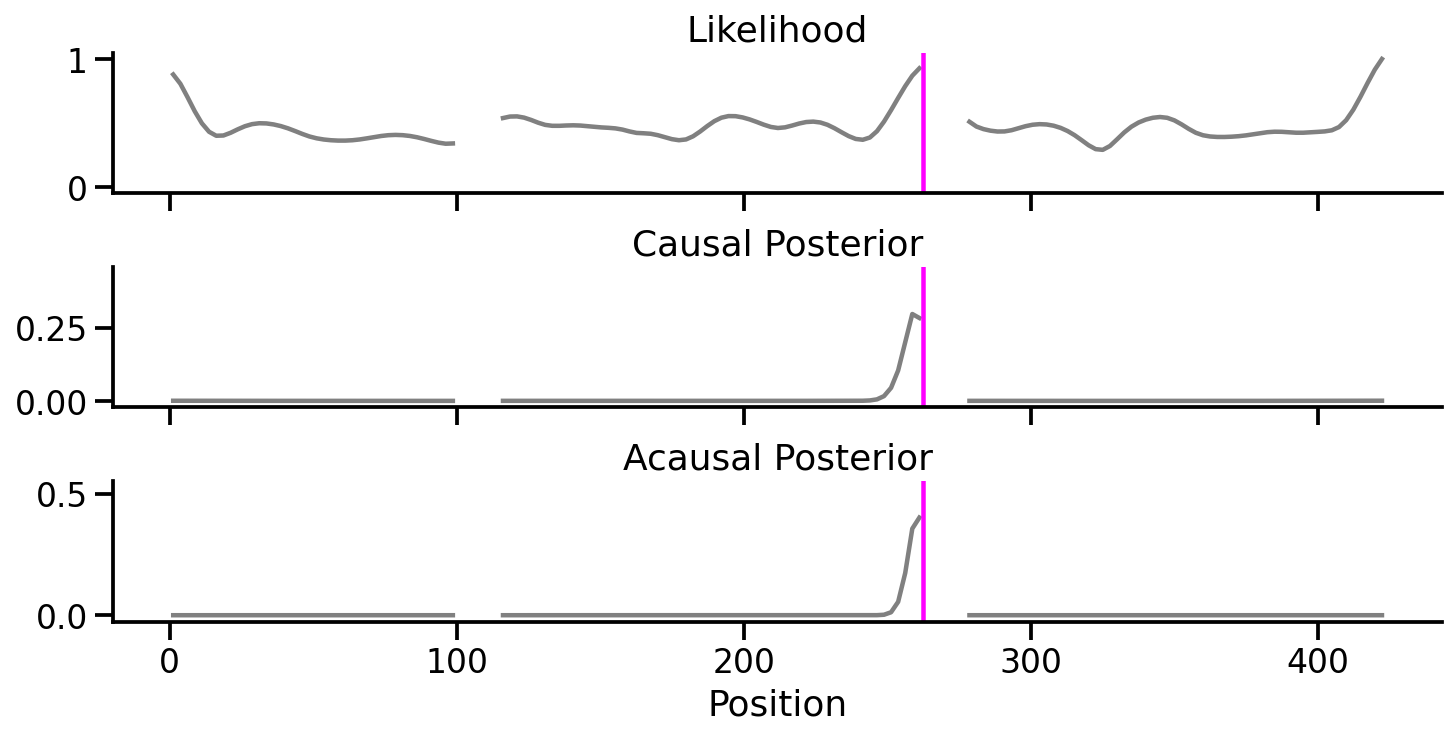

In [25]:
from celluloid import Camera
from IPython.display import HTML

time_slice = results.time[slice(424_625, 424_750)]

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(10, 5))
camera = Camera(fig)
t = data["position_info"].index / np.timedelta64(1, "s")
current_positions = (
    data["position_info"]
    .reset_index()
    .set_index(t)
    .loc[time_slice]
    .linear_position)

for time, current_position in zip(results['likelihood'].sel(time=time_slice).time, current_positions):
    # ax 0
    (results['likelihood']
     .sel(time=time)
     .sel(state='Continuous')
     .where(classifier.is_track_interior_)
     .plot(x='position', ax=axes[0], color='grey'))
    axes[0].set_title('Likelihood')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    axes[0].axvline(current_position, color='magenta')
    
    # ax 1
    (results['causal_posterior']
     .sel(time=time)
     .sum('state')
     .where(classifier.is_track_interior_)
     .plot(x='position', ax=axes[1], color='grey'))
    axes[1].set_title('Causal Posterior')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].axvline(current_position, color='magenta')
    
    # ax 2
    (results['acausal_posterior']
     .sel(time=time)
     .sum('state')
     .where(classifier.is_track_interior_)
     .plot(x='position', ax=axes[2], color='grey'))
    axes[2].set_title('Acausal Posterior')
    axes[2].set_xlabel('Position')
    axes[2].set_ylabel('')
    axes[2].axvline(current_position, color='magenta')
    
    sns.despine()
    camera.snap()
    

animation = camera.animate()
animation.save('animation_increase_smoothing.mp4', dpi=300)

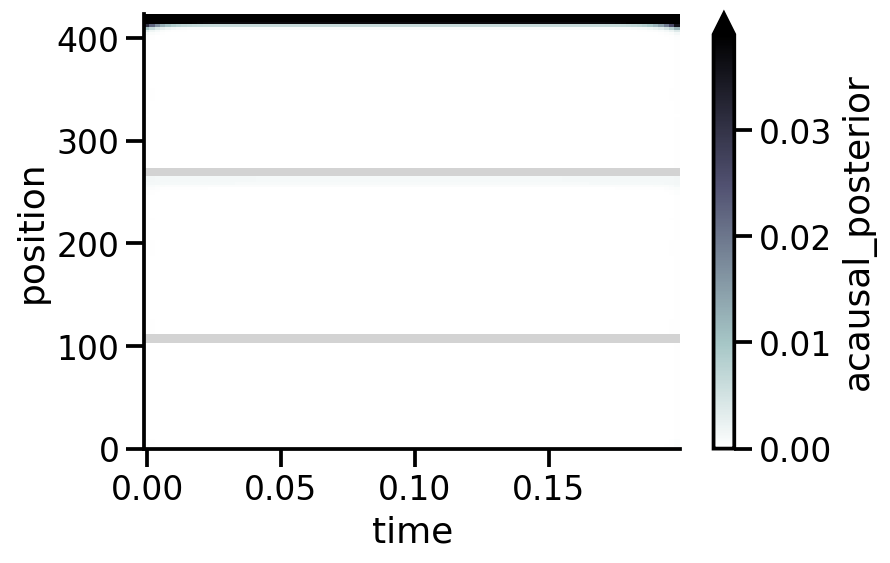

In [26]:
import copy
import matplotlib.pyplot as plt
from src.parameters import SAMPLING_FREQUENCY

n_neurons = data['spikes'].shape[1]
n_time = 100

no_spike_results = (
    classifier.predict(
        np.zeros((n_time, n_neurons)),
        time=np.arange(n_time) / SAMPLING_FREQUENCY,
        state_names=state_names
    )
)

cmap = copy.copy(plt.get_cmap('bone_r'))
cmap.set_bad(color="lightgrey", alpha=1.0)

(no_spike_results
 .acausal_posterior
 .sum('state')
 .where(classifier.is_track_interior_)
 .plot(x='time', y='position', robust=True, vmin=0.0, cmap=cmap))
sns.despine()

In [27]:
is_spike = data['spikes'].iloc[slice(424_700, 425_200)].sum(axis=0) > 0
data['spikes'].columns[is_spike]

Index(['Jaq_03_12_001_002', 'Jaq_03_12_002_018', 'Jaq_03_12_006_029',
       'Jaq_03_12_006_039', 'Jaq_03_12_008_038', 'Jaq_03_12_010_001',
       'Jaq_03_12_010_002', 'Jaq_03_12_010_011', 'Jaq_03_12_011_018',
       'Jaq_03_12_011_019', 'Jaq_03_12_012_005', 'Jaq_03_12_016_002',
       'Jaq_03_12_020_019', 'Jaq_03_12_020_021', 'Jaq_03_12_021_010',
       'Jaq_03_12_021_017', 'Jaq_03_12_023_015', 'Jaq_03_12_025_007',
       'Jaq_03_12_025_027', 'Jaq_03_12_027_005', 'Jaq_03_12_029_001',
       'Jaq_03_12_029_009', 'Jaq_03_12_029_012', 'Jaq_03_12_029_015',
       'Jaq_03_12_029_016', 'Jaq_03_12_029_025', 'Jaq_03_12_030_021'],
      dtype='object')

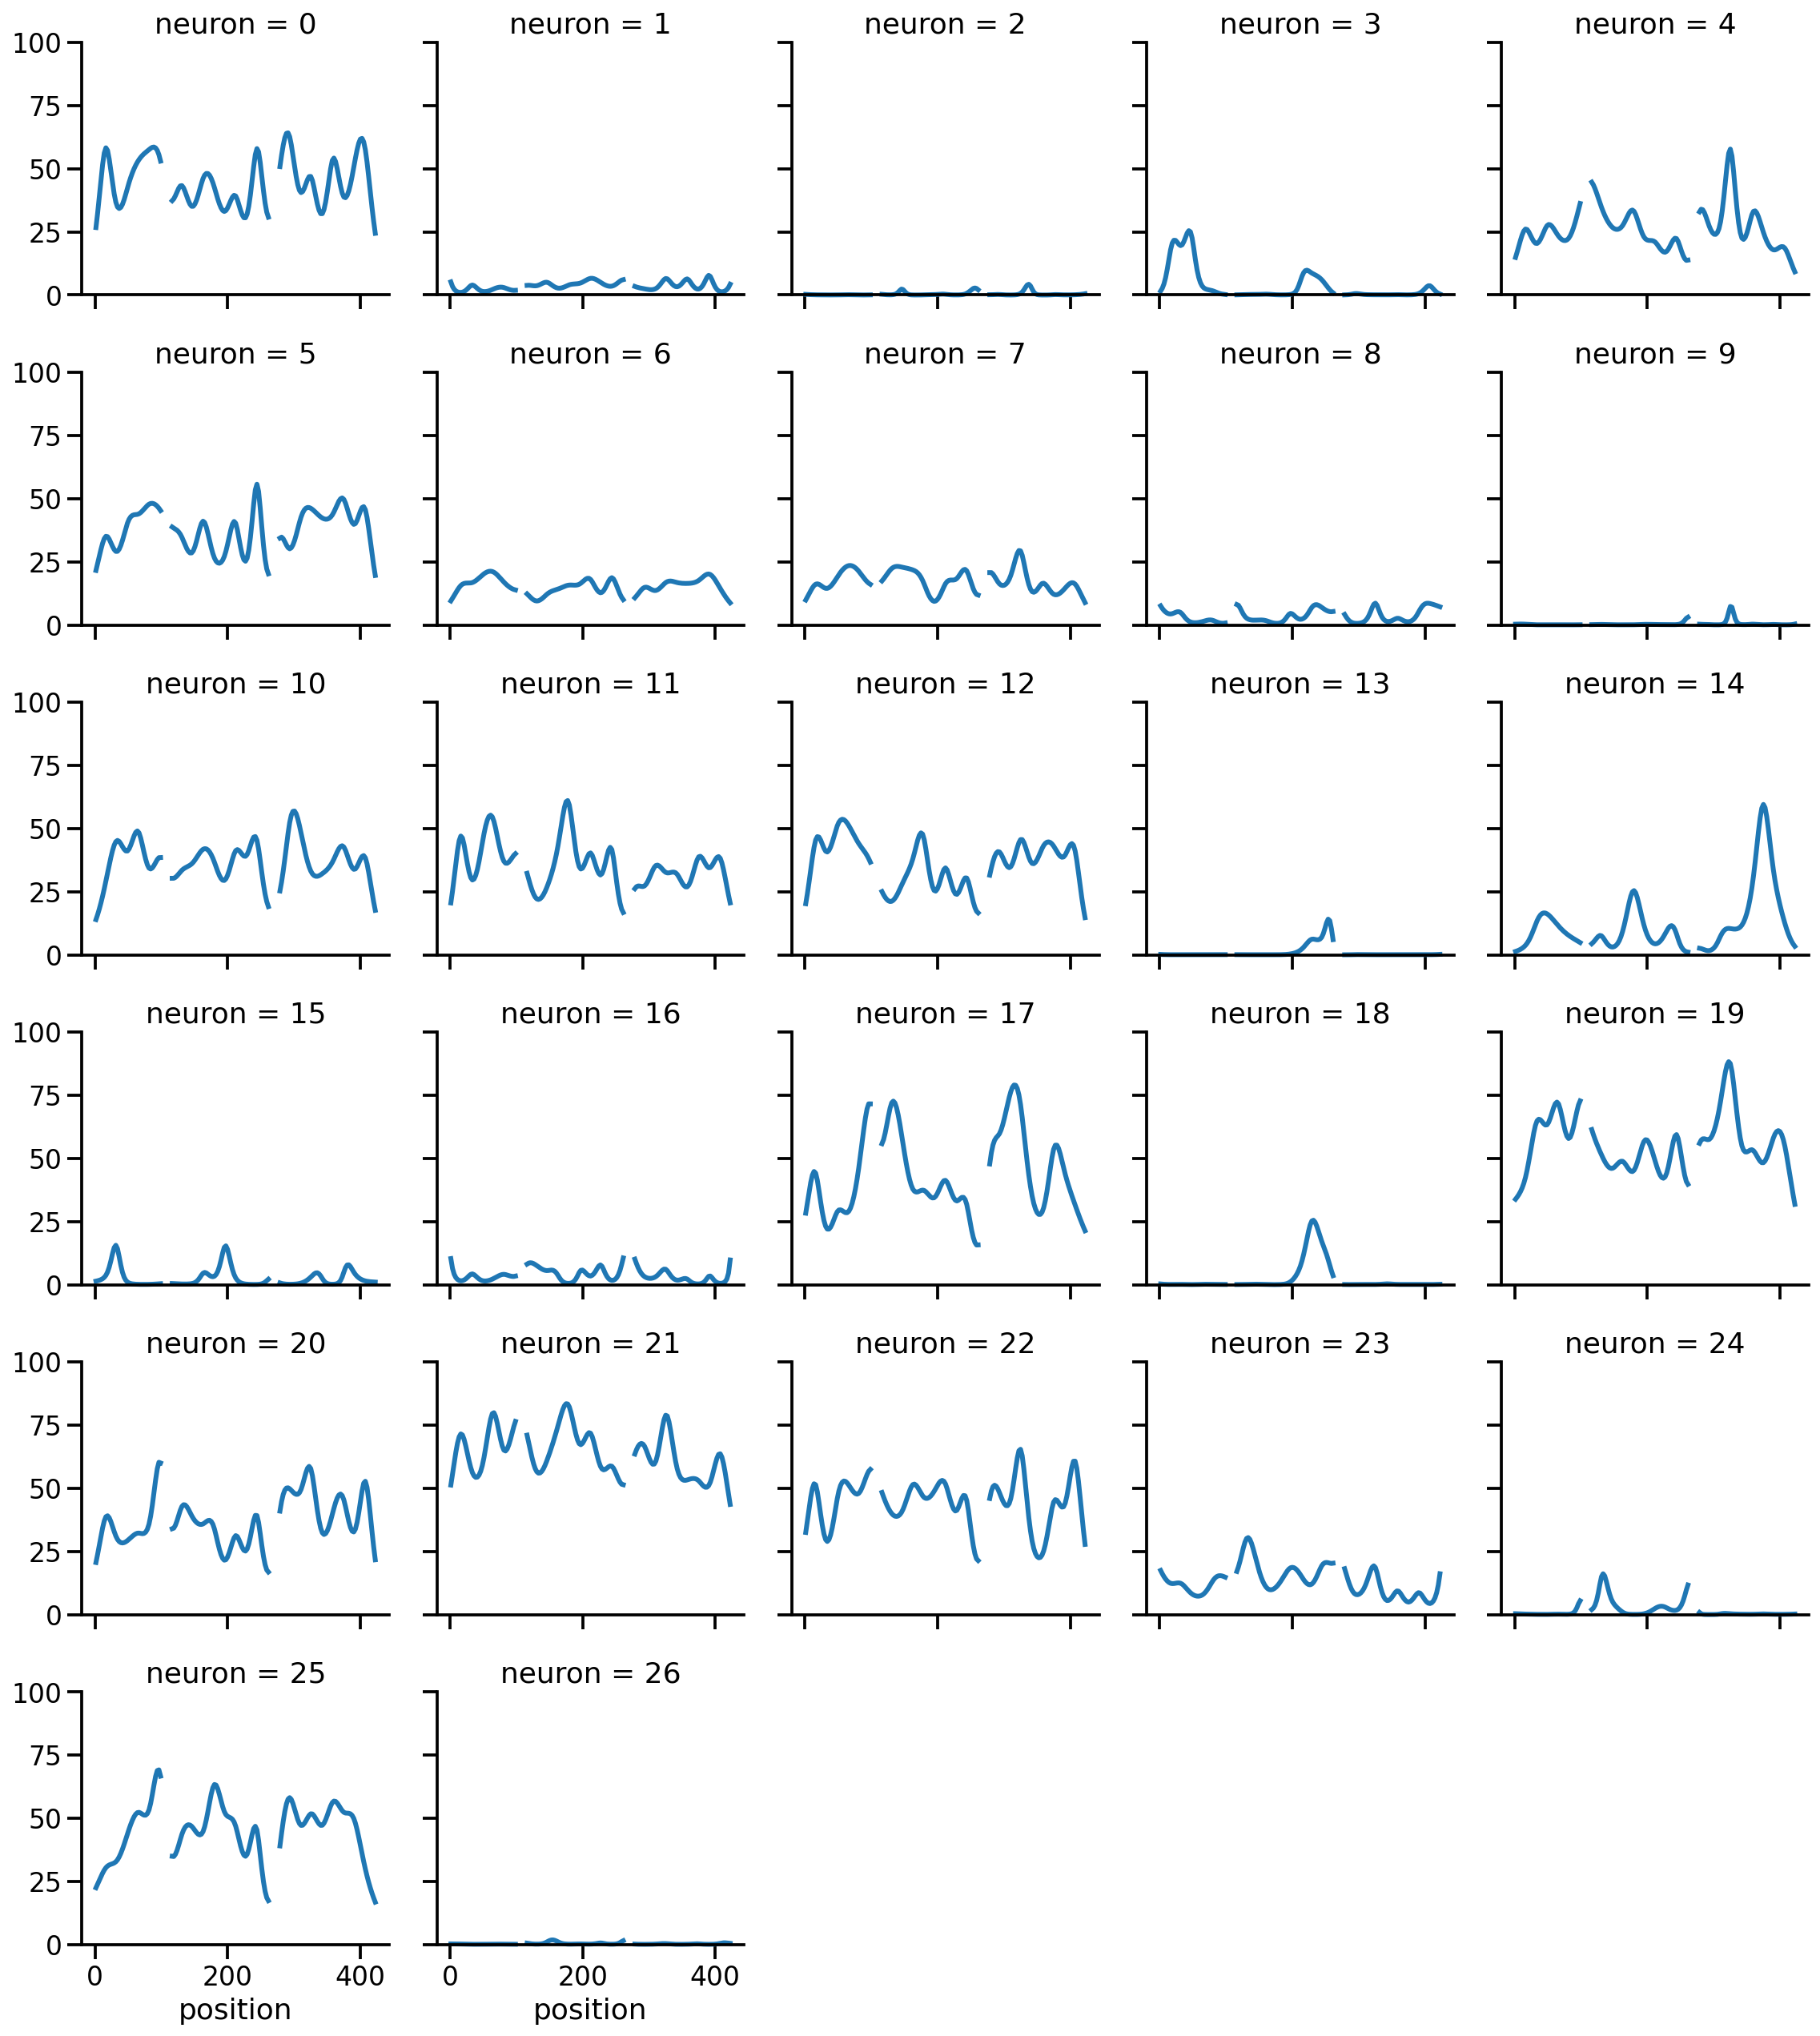

In [28]:
((classifier.place_fields_ * 500)
 .isel(neuron=is_spike)
 .where(classifier.is_track_interior_[np.newaxis, ..., np.newaxis])
 .plot(
    x='position', col='neuron', col_wrap=5, clip_on=False, linewidth=3))
plt.ylim((0, 100))
sns.despine()